# LSLGA/DR8 QA

In [2]:
import os, time
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from astropy.table import vstack, Table, hstack

In [3]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.6)
%matplotlib inline

In [4]:
outdir = '/Users/ioannis/work/legacysurvey/dr8'
#outdir = '/global/project/projectdirs/desi/users/ioannis/dr8-lslga'

In [27]:
#lslgadir = '/global/project/projectdirs/cosmo/staging/largegalaxies/v2.0'
lslgadir = '/Users/ioannis/research/projects/LSLGA/sample/v2.0'
lslgafile = os.path.join(lslgadir, 'LSLGA-v2.0.fits')
lslga = Table.read(lslgafile)
print('Read {} galaxies from {}'.format(len(lslga), lslgafile))

Read 532707 galaxies from /Users/ioannis/research/projects/LSLGA/sample/v2.0/LSLGA-v2.0.fits


In [37]:
cut = lslga['IN_DESI'] * (lslga['D25'] > 1.5)
len(lslga[cut]) * 7 / 14000

1.3605

### Maskbits statistics from the randoms.

The randoms are sampled at 5000/deg.

In [123]:
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # LSLGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
)

In [148]:
randomfile = os.path.join(outdir, 'randoms-inside-dr8-0.31.0-1.fits')
ff = fitsio.FITS(randomfile)
nrows = ff[1].get_nrows()
nrand = 10000000
factor = nrows / nrand / 5000
%time rand = ff[1].read(rows=np.arange(nrand))
print('Read {}/{} random positions from {}'.format(len(rand), nrows, randomfile))

CPU times: user 2.04 s, sys: 2.97 s, total: 5.02 s
Wall time: 5.1 s
Read 10000000/101662375 random positions from /Users/ioannis/work/legacysurvey/dr8/randoms-inside-dr8-0.31.0-1.fits


In [149]:
print(rand.dtype)

[('RA', '>f8'), ('DEC', '>f8'), ('BRICKNAME', 'S8'), ('NOBS_G', '>i2'), ('NOBS_R', '>i2'), ('NOBS_Z', '>i2'), ('PSFDEPTH_G', '>f4'), ('PSFDEPTH_R', '>f4'), ('PSFDEPTH_Z', '>f4'), ('GALDEPTH_G', '>f4'), ('GALDEPTH_R', '>f4'), ('GALDEPTH_Z', '>f4'), ('PSFDEPTH_W1', '>f4'), ('PSFDEPTH_W2', '>f4'), ('PSFSIZE_G', '>f4'), ('PSFSIZE_R', '>f4'), ('PSFSIZE_Z', '>f4'), ('APFLUX_G', '>f4'), ('APFLUX_R', '>f4'), ('APFLUX_Z', '>f4'), ('APFLUX_IVAR_G', '>f4'), ('APFLUX_IVAR_R', '>f4'), ('APFLUX_IVAR_Z', '>f4'), ('MASKBITS', '>i2'), ('WISEMASK_W1', 'u1'), ('WISEMASK_W2', 'u1'), ('EBV', '>f4'), ('PHOTSYS', 'S1'), ('HPXPIXEL', '>i8')]


In [150]:
infoot = (rand['NOBS_G'] > 0) * (rand['NOBS_R'] > 0) * (rand['NOBS_Z'] > 0) * ((rand['MASKBITS'] & MASKBITS['NPRIMARY']) == 0)

In [151]:
totarea = np.sum(infoot) * factor
print('Total area = {:.3f}'.format(totarea))
for bit in MASKBITS.keys():
    area = np.sum(infoot * ((rand['MASKBITS'] & MASKBITS[bit]) != 0) * factor)
    frac = 100 * area / totarea
    print('  {}: {:.3f} deg2, {:.3f}%'.format(bit, area, frac))

Total area = 19432.098
  NPRIMARY: 0.000 deg2, 0.000%
  BRIGHT: 545.746 deg2, 2.808%
  SATUR_G: 29.279 deg2, 0.151%
  SATUR_R: 50.917 deg2, 0.262%
  SATUR_Z: 40.754 deg2, 0.210%
  ALLMASK_G: 0.000 deg2, 0.000%
  ALLMASK_R: 0.000 deg2, 0.000%
  ALLMASK_Z: 0.000 deg2, 0.000%
  WISEM1: 555.709 deg2, 2.860%
  WISEM2: 281.239 deg2, 1.447%
  BAILOUT: 0.028 deg2, 0.000%
  MEDIUM: 899.694 deg2, 4.630%
  GALAXY: 15.318 deg2, 0.079%
  CLUSTER: 1.167 deg2, 0.006%


### LSLGA input/output fitting results.

In [6]:
def read_dr8_lslga(region='north', clobber=False):
    sweepdir = '/global/project/projectdirs/cosmo/work/legacysurvey/dr8/{}/sweep/8.0/'.format(region)
    
    outfile = os.path.join(outdir, 'dr8-lslga-{}.fits'.format(region))
    if os.path.isfile(outfile) and not clobber:
        print('Reading {}'.format(outfile))
        out = Table.read(outfile)
    else:
        out = []
        catfile = glob(os.path.join(sweepdir, 'sweep*.fits'))
        for ii, ff in enumerate(catfile):
            if ii % 50 == 0:
                print('{} / {}'.format(ii, len(catfile)))
            cc = Table(fitsio.read(ff, columns=['REF_CAT', 'REF_ID', 'RA', 'DEC', 'TYPE', 'FRACDEV',
                                                'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2', 
                                                'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2'], upper=True))
            ckeep = np.where(cc['REF_CAT'] == 'L2')[0]
            #keep = np.where([rcat.decode('utf-8').strip() == 'L2' for rcat in cc['REF_CAT']])[0]
            if len(ckeep) > 0:
                cc = cc[ckeep]
                cc = cc[np.argsort(cc['REF_ID'])] # sort!
                _, uu = np.unique(cc['REF_ID'], return_index=True)
                if len(uu) != len(cc):
                    print('Duplicate large galaxy in {}'.format(os.path.basename(ff)))
                    cc = cc[uu]
                lkeep = np.where(np.isin(lslga['LSLGA_ID'], cc['REF_ID']))[0]
                if len(lkeep) != len(cc):
                    print('Still a problem with duplicates!')
                lss = lslga[lkeep]
                assert(np.all(lss['LSLGA_ID'] == cc['REF_ID']))
                lss.rename_column('RA', 'RA_LSLGA')
                lss.rename_column('DEC', 'DEC_LSLGA')
                lss.rename_column('TYPE', 'MORPHTYPE')
                out.append(hstack((lss, cc)))
                #import pdb ; pdb.set_trace()
        out = vstack(out)
        out.write(outfile, overwrite=True)
    return out

In [12]:
%time north = read_dr8_lslga(region='north', clobber=False)
%time south = read_dr8_lslga(region='south', clobber=False)

Reading /Users/ioannis/work/legacysurvey/dr8/dr8-lslga-north.fits
CPU times: user 204 ms, sys: 162 ms, total: 366 ms
Wall time: 452 ms
Reading /Users/ioannis/work/legacysurvey/dr8/dr8-lslga-south.fits
CPU times: user 169 ms, sys: 313 ms, total: 482 ms
Wall time: 619 ms


In [23]:
cat = vstack((north, south))
print('Read {} large galaxies.'.format(len(cat)))
cat[:5]

Read 403574 large galaxies.


LSLGA_ID,GALAXY,PGC,RA_LSLGA,DEC_LSLGA,MORPHTYPE,BAR,RING,MULTIPLE,COMPACTNESS,T,PA,D25,BA,DIAM_REF,Z,SB_D25,MAG,MAG_REF,WISE_RA,WISE_DEC,CNTR,W1MPRO,W1SIGMPRO,W2MPRO,W2SIGMPRO,W3MPRO,W3SIGMPRO,W4MPRO,W4SIGMPRO,RCHI2,CC_FLAGS,EXT_FLG,PH_QUAL,XSCPROX,W1RSEMI,W1BA,W1PA,W1GMAG,W1GERR,W2GMAG,W2GERR,W3GMAG,W3GERR,W4GMAG,W4GERR,IN_ALLWISE,IN_DESI,NEAR_BRIGHTSTAR,TYPE,RA,DEC,FRACDEV,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,REF_CAT,REF_ID
int64,bytes29,int64,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,bytes3,float32,float32,float32,bytes1,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bytes4,float64,float64,float32,float32,float32,float32,float32,float32,float32,bytes2,int64
12442,PGC028345,28345,147.7114455,29.8524533,Sc,nan,nan,nan,nan,5.5,23.87,0.36897758,0.56234133,iso,0.046555206,23.26548,16.802,B,147.7114435,29.8524509,1478130201351018772,13.613,0.026,13.387,0.032,9.289,0.037,7.419,0.131,2.998,0000,1,AAAB,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False,EXP,147.71142640793477,29.852498819453796,0.0,0.0,0.0,0.0,4.4805136,0.22624908,0.12122772,L2,12442
14446,PGC1884023,1884023,141.4297125,29.9424196,E?,nan,nan,nan,nan,-5.0,94.47,0.36307806,0.36307806,iso,0.059890766,24.66048,18.232,B,141.4298823,29.9424617,1408130201351023996,13.668,0.025,13.434,0.032,10.085,0.062,8.421,0.314,1.954,0000,1,AAAB,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False,EXP,141.42986142163176,29.942504249477427,0.0,0.0,0.0,0.0,4.4602566,-0.57790524,-0.10098956,L2,14446
19947,PGC1877495,1877495,142.170381,29.7689757,E,nan,nan,nan,nan,-5.0,9.32,0.38018936,0.66069347,iso,0.07625942,23.79648,17.268,B,142.170279,29.7688282,1426130201351007916,13.036,0.025,12.996,0.028,11.555,nan,8.741,nan,2.187,0000,1,AAUU,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False,DEV,142.17025691902475,29.768801860243855,1.0,3.0224175,0.23296604,0.016352246,0.0,0.0,0.0,L2,19947
21242,PGC1872898,1872898,146.7535575,29.640062300000004,Sc,nan,nan,M,nan,6.0,58.69,0.38018936,0.56234133,iso,0.11052646,23.46348,16.935,B,146.7535902,29.6400522,1460130201351000035,13.713,0.029,13.408,0.034,10.266,0.081,8.511,0.478,1.49,0000,4,AAAC,0.05,9.21,0.85,75.0,13.612,0.01,13.384,0.018,10.666,0.061,9.267,0.657,True,True,False,COMP,146.75364290589863,29.640130274515595,0.10321888,0.3431571,-0.11160513,0.17594124,8.116938,-0.1327871,0.2121332,L2,21242
27112,PGC1860853,1860853,147.31865249999998,29.263690999999998,Sb,nan,R,nan,nan,3.0,32.1,0.5248075,0.5128614,iso,0.052325867,23.296482,16.068,B,147.3188905,29.2639921,1474128701351058347,12.844,0.03,12.831,0.033,11.947,0.391,8.57,nan,2.283,0000,5,AACU,1.01,11.94,0.69,35.0,12.561,0.007,12.6,0.014,11.491,0.149,nan,nan,True,True,False,DEV,147.31869297252823,29.263672785955695,1.0,6.204858,0.12940481,0.31877816,0.0,0.0,0.0,L2,27112


In [15]:
def qa_radec(png=None):
    dra, ddec = (cat['RA'] - cat['RA_LSLGA']).data * 3600, (cat['DEC'] - cat['DEC_LSLGA']).data * 3600
    print(np.median(dra), np.std(dra), np.median(ddec), np.std(ddec))
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(dra, ddec, s=50)
    ax.set_xlim(-40, 40)
    ax.set_ylim(-40, 40)
    ax.axhline(y=0, ls='-', alpha=0.8, color='k')
    ax.axvline(x=0, ls='-', alpha=0.8, color='k')
    ax.set_xlabel(r'$\Delta\,$(RA) (arcsec)')
    ax.set_ylabel(r'$\Delta\,$(Dec) (arcsec)')
    plt.subplots_adjust(bottom=0.15, left=0.15)
    if png:
        pngfile = os.path.join(outdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)

0.017672798699663872 2.3830860211421636 -0.009383424001008223 1.258157572443718
Writing /Users/ioannis/work/legacysurvey/dr8/qa-radec.png


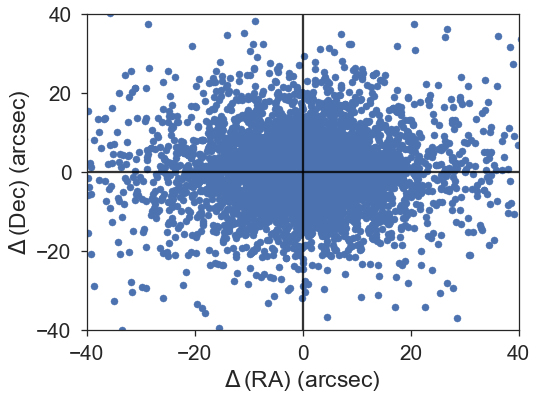

In [16]:
qa_radec(png='qa-radec.png')

In [20]:
def get_e1e2(ba, phi):
    ab = 1. / ba
    e = (ab - 1) / (ab + 1)
    ee = -np.log(1 - e)
    angle = np.deg2rad(2. * (-phi))
    ee1 = ee * np.cos(angle)
    ee2 = ee * np.sin(angle)
    return ee1, ee2
        
def type2properties(cat, objtype):
    this = np.where([objtype == tt.strip() for tt in cat['TYPE']])[0]
    if objtype == 'EXP' or objtype == 'REX':
        reff, e1, e2 = cat['SHAPEEXP_R'][this], cat['SHAPEEXP_E1'][this], cat['SHAPEEXP_E2'][this]
    elif objtype == 'DEV':
        reff, e1, e2 = cat['SHAPEDEV_R'][this], cat['SHAPEDEV_E1'][this], cat['SHAPEDEV_E2'][this]
        
    lslga_rad = cat['D25'][this] / 2 * 60 / 2 # [arcmin]
    lslga_e1, lslga_e2 = get_e1e2(cat['BA'][this], 180-cat['PA'][this])
        
    return reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, cat[this]

In [21]:
def qa_morph(png=None):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    #for objtype in ('COMP', 'DEV', 'EXP', 'PSF', 'REX'):
    for objtype, marker in zip(('DEV', 'EXP', 'REX'), ('s', 'o', '*')):
        reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, _ = type2properties(cat, objtype)
        ax[0].scatter(reff, lslga_rad, label=objtype, s=20, alpha=0.7, marker=marker)
        if objtype != 'REX':
            ax[1].scatter(e1, lslga_e1, s=20, alpha=0.7, marker=marker)
            ax[2].scatter(e2, lslga_e2, s=20, alpha=0.7, marker=marker)
    ax[0].set_xlim(0, 40)
    ax[0].set_ylim(0, 40)
    ax[0].axhline(y=5, color='k')
    ax[0].set_xlabel(r'r$_{eff}$ (Tractor, arcsec)')
    ax[0].set_ylabel(r'0.5 * R(25) (LSLGA, arcsec)')
    ax[1].set_xlabel(r'e$_1$ (Tractor)')
    ax[1].set_ylabel(r'e$_1$ (LSLGA)')
    ax[2].set_xlabel(r'e$_2$ (Tractor)')
    ax[2].set_ylabel(r'e$_2$ (LSLGA)')
    for xx in ax[1:]:
        xx.set_xlim(-1, 1)
        xx.set_ylim(-1, 1)
    leg = ax[0].legend(loc='upper left', frameon=True, fontsize=16, markerscale=2)
    for l in leg.get_lines():
        l.set_alpha(1)
    for xx in ax:
        xx.plot(xx.get_xlim(), xx.get_ylim(), color='k', ls='--')
    plt.subplots_adjust(wspace=0.35, bottom=0.2)
    if png:
        pngfile = os.path.join(outdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)    

Writing /Users/ioannis/work/legacysurvey/dr8/qa-lslga-morph.png


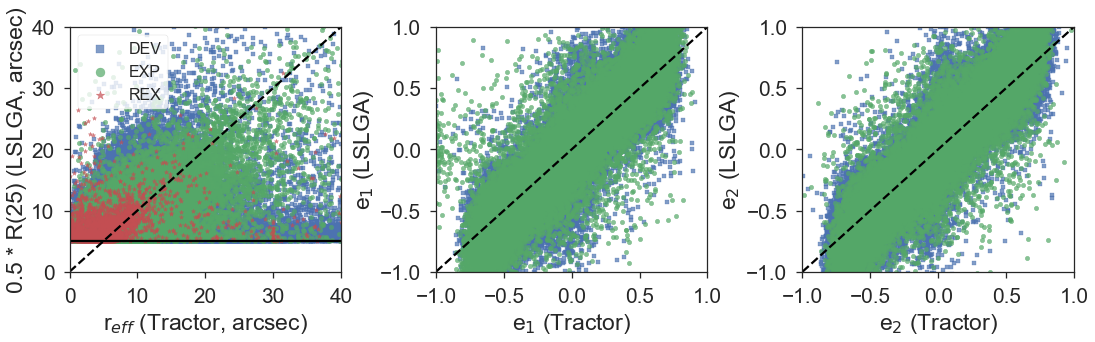

In [22]:
qa_morph(png='qa-lslga-morph.png')

In [95]:
def qa_maskbits(png=None):
    from astropy.visualization import AsinhStretch as Stretch
    from astropy.visualization import ImageNormalize
    from astropy.visualization import ZScaleInterval as Interval
     
    brick = '1927p412'
    img = fitsio.read(os.path.join(outdir, 'legacysurvey-{}-image-r.fits.fz'.format(brick)))
    msk = fitsio.read(os.path.join(outdir, 'legacysurvey-{}-maskbits.fits.fz'.format(brick)))
        
    cmap = plt.cm.viridis
    stretch = Stretch(a=0.9)
    interval = Interval(contrast=0.5, nsamples=10000)
    norm = ImageNormalize(img, interval=interval, stretch=stretch)
       
    inchperax = 4
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(inchperax*3, 3))
    ax[0].imshow(img, origin='lower', norm=norm, cmap=cmap, interpolation='none')
    ax[1].imshow((msk & 2**12) != 0, origin='lower', interpolation='none')
    ax[2].imshow((msk & 2**1) != 0, origin='lower', interpolation='none')
    for xx in ax:
        xx.get_xaxis().set_visible(False)
        xx.get_yaxis().set_visible(False)
        xx.set_aspect('equal')
        xx.axis('off')
        xx.autoscale(False)
    fig.subplots_adjust(wspace=0)
    plt.tight_layout(w_pad=0)
    
    if png:
        pngfile = os.path.join(outdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile, bbox_inches='tight')#, pad_inches=0)

Writing /Users/ioannis/work/legacysurvey/dr8/qa-maskbits.png


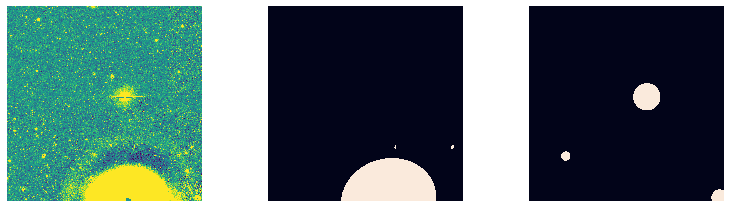

In [96]:
qa_maskbits(png='qa-maskbits.png')

In [ ]:
stop

In [ ]:
reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, devcat = type2properties(cat, 'DEV')
big = np.where(reff > 25)[0]
for cc in devcat[big][:20]:
    size = np.round(cc['D25'] * 1.5 * 60 / 0.262).astype(int)
    montagefile = 'montage/{}.jpg'.format(cc['GALAXY'].lower())
    jpgfile = []
    #print('http://legacysurvey.org/viewer-dev?ra={}&dec={}&zoom=14&layer=dr8b-decam&lslga'.format(cc['RA'], cc['DEC']))
    for ii, imtype in enumerate(('', '-model', '-resid')):
        jpgfile.append('jpg/{}{}.jpg'.format(cc['GALAXY'].lower(), imtype))
        url = '"http://legacysurvey.org/viewer-dev/jpeg-cutout?ra={}&dec={}&size={}&layer=dr8b-decam{}"'.format(
            cc['RA'], cc['DEC'], size, imtype)
        if not os.path.exists(jpgfile[ii]):
            cmd = 'wget --continue -O {} {}'.format(jpgfile[ii], url)
            print(cmd)
            os.system(cmd)
            time.sleep(1)
    cmd = 'montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 '
    cmd = cmd+' '.join(ff for ff in jpgfile)
    cmd = cmd+' {}'.format(montagefile)
    print(cmd)
    os.system(cmd)    